## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  #regular expression
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

## Loadinf the dataset

In [2]:
df = pd.read_csv('/kaggle/input/fake-news-dataset/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [4]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Data Preprocessing

In [6]:
# droping unnecessary columns
df = df.drop(columns=['id','title','author'],axis=1)

In [7]:
# droping null rows
df = df.dropna(axis=0)

In [8]:
len(df)

20761

In [9]:
#converting to lower case
df['clean_news'] = df['text'].str.lower()
#removing unwanted characters and spaces
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799     david swanson is an author activist journalis...
Name: clean_news, Length: 20761, dtype: object

In [10]:
# removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x:" ".join([word for word in x.split() if word not in stop]))
df.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


## Exploratory Data Analysis

In [11]:
from wordcloud import WordCloud

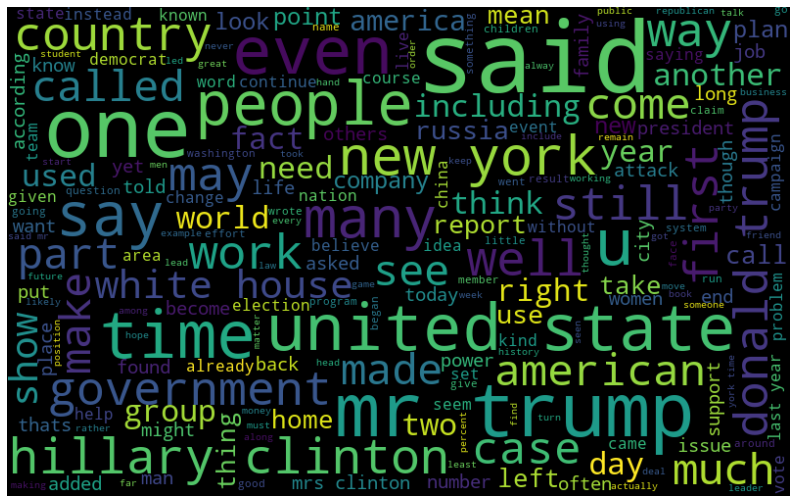

In [12]:
# visualizing the frequent words
all_words = " ".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

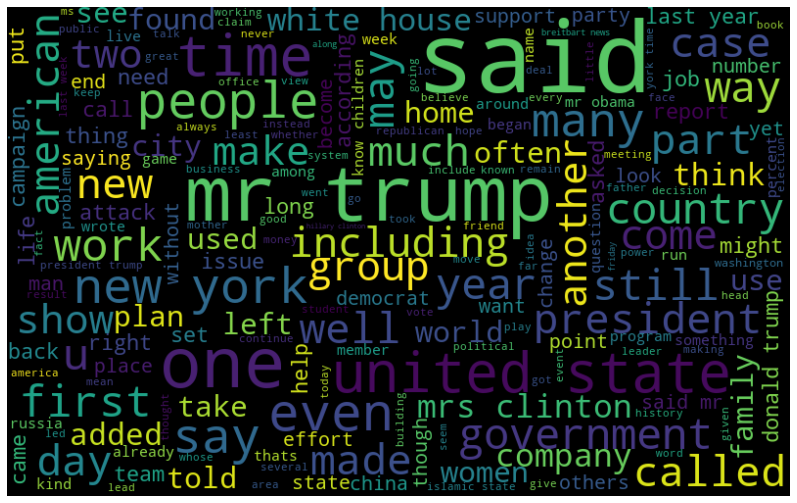

In [13]:
# visualizing the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

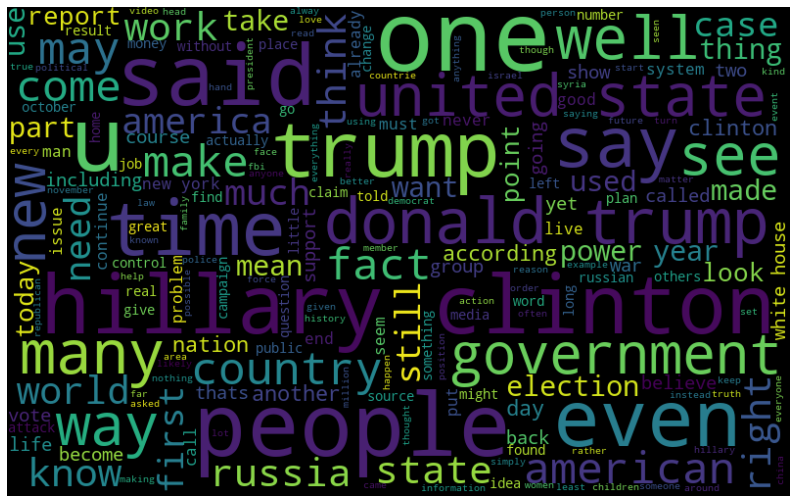

In [14]:
# visualizing the frequent words for fake news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plotting the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creating Word Embeddings

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
# tokenizing text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

199536

In [17]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [18]:
# CREATING EMBEDDING INDEX

embedding_index = {}
with open('/kaggle/input/glove6b/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        #print(values)
        word = values[0]
        # each word is of 100 dimension
        coefs = np.asarray(values[1:],dtype='float32')
        embedding_index[word]=coefs

In [19]:
# CREATING EMBEDDING MATRIX

embedding_matrix = np.zeros((vocab_size+1,100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix[1]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

## Splitting

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(padded_seq, df['label'], test_size=0.2, random_state=42,stratify=df['label'])

## MODEL CREATION

In [22]:
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential

model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
    # we can also use multiple LSTM and Dense layer
])

2023-01-30 05:09:04.580312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:09:04.676433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:09:04.677342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:09:04.680100: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         19953700  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 20,104,229
Trainable params: 150,529
Non-trainable params: 19,953,700
______________________________________

In [24]:
## Traininf the model
history = model.fit(x_train,y_train,epochs=60,batch_size=256,validation_data=(x_test,y_test))

Epoch 1/60


2023-01-30 05:09:07.968848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-30 05:09:10.277658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 7s 57ms/step - loss: 0.6302 - accuracy: 0.6425 - val_loss: 0.5939 - val_accuracy: 0.6680
Epoch 2/60
65/65 [==============================] - 3s 50ms/step - loss: 0.5892 - accuracy: 0.6783 - val_loss: 0.5820 - val_accuracy: 0.6911
Epoch 3/60
65/65 [==============================] - 3s 50ms/step - loss: 0.5911 - accuracy: 0.6706 - val_loss: 0.6405 - val_accuracy: 0.6369
Epoch 4/60
65/65 [==============================] - 3s 50ms/step - loss: 0.5955 - accuracy: 0.6715 - val_loss: 0.5484 - val_accuracy: 0.7448
Epoch 5/60
65/65 [==============================] - 3s 51ms/step - loss: 0.5435 - accuracy: 0.7091 - val_loss: 0.5552 - val_accuracy: 0.7192
Epoch 6/60
65/65 [==============================] - 3s 50ms/step - loss: 0.5772 - accuracy: 0.6647 - val_loss: 0.5358 - val_accuracy: 0.7373
Epoch 7/60
65/65 [==============================] - 3s 51ms/step - loss: 0.5329 - accuracy: 0.7410 - val_loss: 0.5391 - val_accuracy: 0.7325
Epoch 8/60
65/65 [======

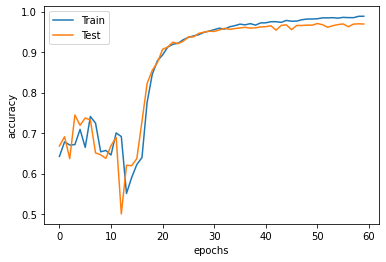

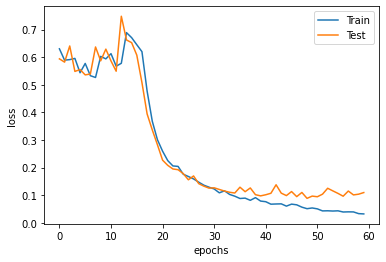

In [25]:
# visualizing the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [26]:
## train_accuracy: 0.9958 
## test_accuracy: 0.9603